In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Define the column data types
column_types = {
    'Global_active_power': 'float64',
    'Global_reactive_power': 'float64',
    'Voltage': 'float64',
    'Global_intensity': 'float64',
    'Sub_metering_1': 'float64',
    'Sub_metering_2': 'float64',
    'Sub_metering_3': 'float64'
}

In [8]:
# Load the dataset and specify column data types and na_values
data = pd.read_csv('household_power_consumption.txt.zip', delimiter=';', dtype=column_types, na_values='?')
data


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [9]:
# Drop rows with missing values
data = data.dropna()

# Drop the 'Date' and 'Time' columns
data = data.drop(columns=['Date', 'Time'])

# Transform the dataset to include variables at (t-1) and (t)
shifted_data = data.shift(1)
shifted_data.columns = [f'{col}_t-1' for col in shifted_data.columns]
shifted_data['Global_active_power_t'] = data['Global_active_power']
shifted_data = shifted_data.dropna()
shifted_data


,Global_active_power_t-1,Global_reactive_power_t-1,Voltage_t-1,Global_intensity_t-1,Sub_metering_1_t-1,Sub_metering_2_t-1,Sub_metering_3_t-1,Global_active_power_t
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5.360
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5.374
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.388
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,3.666
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,3.520
...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.33,4.0,0.0,0.0,0.0,0.946
2075255,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.944
2075256,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.938
2075257,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.934


In [10]:
# Split the data into train and test subsets
X = shifted_data.drop(columns=['Global_active_power_t'])
y = shifted_data['Global_active_power_t']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("X_train_scaled",X_train_scaled.shape)
print("X_test_scaled",X_test_scaled.shape)

X_train_scaled (1639423, 7)
X_test_scaled (409856, 7)


In [14]:
# Reshape the input data for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
print("X_train_scaled",X_train_scaled.shape)
print("X_test_scaled",X_test_scaled.shape)

X_train_scaled (1639423, 1, 7)
X_test_scaled (409856, 1, 7)


In [17]:
# Create the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(tf.keras.layers.Dense(1))

print("X_train_scaled.shape[1]",X_train_scaled.shape[1])
print("X_train_scaled.shape[2]",X_train_scaled.shape[2])

X_train_scaled.shape[1] 1
X_train_scaled.shape[2] 7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test), verbose=2)

# Make predictions
y_pred = model.predict(X_test_scaled)

Epoch 1/10
25616/25616 - 91s - 4ms/step - loss: 0.0653 - val_loss: 0.0660
Epoch 2/10
25616/25616 - 141s - 5ms/step - loss: 0.0652 - val_loss: 0.0659
Epoch 3/10
25616/25616 - 143s - 6ms/step - loss: 0.0651 - val_loss: 0.0659
Epoch 4/10
25616/25616 - 140s - 5ms/step - loss: 0.0650 - val_loss: 0.0658
Epoch 5/10
25616/25616 - 86s - 3ms/step - loss: 0.0649 - val_loss: 0.0660
Epoch 6/10
25616/25616 - 143s - 6ms/step - loss: 0.0648 - val_loss: 0.0659
Epoch 7/10
25616/25616 - 142s - 6ms/step - loss: 0.0648 - val_loss: 0.0656
Epoch 8/10
25616/25616 - 87s - 3ms/step - loss: 0.0647 - val_loss: 0.0652
Epoch 9/10
25616/25616 - 144s - 6ms/step - loss: 0.0647 - val_loss: 0.0658
Epoch 10/10
25616/25616 - 153s - 6ms/step - loss: 0.0646 - val_loss: 0.0654
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


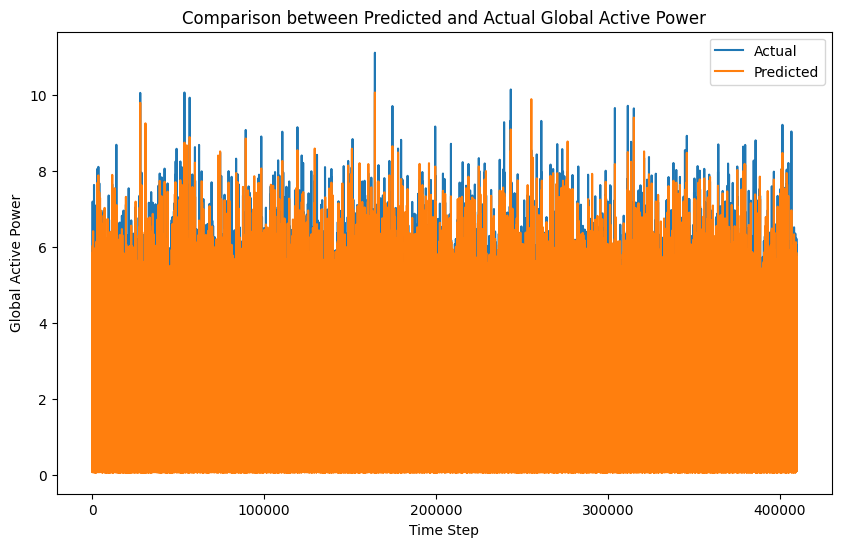

In [20]:
# Visualize the comparison between predicted and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Comparison between Predicted and Actual Global Active Power')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.show()